In [ ]:
!#cd ..; python3 python/scripts/preprocess_bgl3.py

In [1]:
import random
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from utils import mutate_wt, truncate_seq_from_asterisk_onwards

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# imports for machine learning
import tensorflow as tf
import keras.utils

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [4]:
single_mutation_file = "../data/working/Bgl3_single_mutations.tsv"
double_mutation_file = "../data/working/Bgl3_double_mutations.tsv"

In [5]:
single_mutations = pd.read_csv(single_mutation_file, sep="\t")
double_mutations = pd.read_csv(double_mutation_file, sep="\t")

In [6]:
single_mutations.describe()[:1]

,Unnamed: 0,positive,unsorted,positive_hitemp
count,5573.0,4522.0,4435.0,4054.0


In [7]:
double_mutations.describe()[:1]

,Unnamed: 0,positive,unsorted,positive_hitemp
count,523013.0,202618.0,263530.0,198481.0


In [8]:
# Set up constants for wild type and alphabets
WT_Bgl3 = 'MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSIWDTYARTPGRVRNGDTGDVATDHYHRWREDVALMAELGLGAYRFSLAWPRIQPTGRGPALQKGLDFYRRLADELLAKGIQPVATLYHWDLPQELENAGGWPERATAERFAEYAAIAADALGDRVKTWTTLNEPWCSAFLGYGSGVHAPGRTDPVAALRAAHHLNLGHGLAVQALRDRLPADAQCSVTLNIHHVRPLTDSDADADAVRRIDALANRVFTGPMLQGAYPEDLVKDTAGLTDWSFVRDGDLRLAHQKLDFLGVNYYSPTLVSEADGSGTHNSDGHGRSAHSPWPGADRVAFHQPPGETTAMGWAVDPSGLYELLRRLSSDFPALPLVITENGAAFHDYADPEGNVNDPERIAYVRDHLAAVHRAIKDGSDVRGYFLWSLLDNFEWAHGYSKRFGAVYVDYPTGTRIPKASARWYAEVARTGVLPTAGDPNSSSVDKLAAALEHHHHHH*'
# Remove the asterisk at the end
WT_Bgl3 = np.array(list(truncate_seq_from_asterisk_onwards(WT_Bgl3)))

# Find all the unique letters
ALPHABET = np.array([l for l in set(WT_Bgl3) if l != "*"])
ALPHABET.sort()
ALPHABET_SIZE = len(ALPHABET)
print("ALPHABET =", ALPHABET)
print("ALPHABET_SIZE =", ALPHABET_SIZE)

WT_SIZE = len(WT_Bgl3)
print("WT_SIZE = ", WT_SIZE)

# This is an integer representation of the WT (index positions of the ALPHABET)
WT_INDEX = ALPHABET.searchsorted(WT_Bgl3)
print("WT       (first few elements) = ", WT_Bgl3[:15])
print("WT_INDEX (first few elements) = ", WT_INDEX[:15])

ALPHABET = ['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
ALPHABET_SIZE = 20
WT_SIZE =  501
WT       (first few elements) =  ['M' 'V' 'P' 'A' 'A' 'Q' 'Q' 'T' 'A' 'M' 'A' 'P' 'D' 'A' 'A']
WT_INDEX (first few elements) =  [10 17 12  0  0 13 13 16  0 10  0 12  2  0  0]


In [9]:
# Lets do a couple of mutations and check
print("Wildtype Index (first few elements) :", WT_INDEX[:10])
print("Mutated Index  (first few elements) :", mutate_wt(WT_INDEX, ALPHABET, "A4F", "A5L")[:10])

Wildtype Index (first few elements) : [10 17 12  0  0 13 13 16  0 10]
Mutated Index  (first few elements) : [10 17 12  4  9 13 13 16  0 10]


### Construct training data

In [10]:
wt_one_hot = keras.utils.to_categorical(WT_INDEX, ALPHABET_SIZE)
print("Wild Type One Hot\n", wt_one_hot)
print("Wild Type One Hot Shape", wt_one_hot.shape)
print("Wild Type One Hot Flattened Shape", wt_one_hot.flatten().shape)

Wild Type One Hot
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Wild Type One Hot Shape (501, 20)
Wild Type One Hot Flattened Shape (10020,)


In [11]:
# filter out mutations that have an asterisk in them. 
# Also keep only positive mutations
single_positive_mutations = single_mutations.mutations[ (~ single_mutations.mutations.str.contains("*", regex=False)) & 
                               (single_mutations.positive == 1.0) ]

single_positive_mutations.head()

1    A104D
2    A104E
3    A104G
4    A104K
5    A104P
Name: mutations, dtype: object

In [12]:
double_positive_mutations =  double_mutations.mutations[ (~ double_mutations.mutations.str.contains("*", regex=False)) & 
                               (double_mutations.positive == 1.0) ]
double_positive_mutations.head()

0    A104D,N383K
1    A104E,A142E
2    A104E,A155S
3    A104E,A158V
4    A104E,E147D
Name: mutations, dtype: object

In [13]:
positive_mutations = list(single_positive_mutations) + list(double_positive_mutations)
positive_mutations = random.sample(positive_mutations, 15000)

In [14]:
training_data = np.vstack(
    (keras.utils.to_categorical(
        mutate_wt(WT_INDEX, ALPHABET, *mut.split(",")), ALPHABET_SIZE).flatten() for mut in positive_mutations))

training_data.shape

(15000, 10020)

### Construct the AutoEncoder Model

[VAE code taken from keras example](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)

In [15]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
# network parameters
original_dim = WT_SIZE * ALPHABET_SIZE
input_shape = (original_dim, )
intermediate_dim = 256
batch_size = 20
latent_dim = 2
epochs = 4
np.random.seed(1)

In [17]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 10020)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          2565376     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

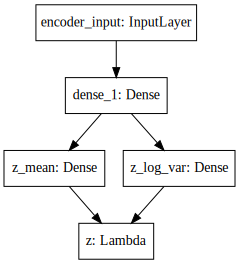

In [18]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_3 (Dense)              (None, 10020)             2575140   
Total params: 2,575,908
Trainable params: 2,575,908
Non-trainable params: 0
_________________________________________________________________


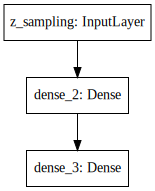

In [19]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))

In [20]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [21]:
#from keras.losses import binary_crossentropy

## VAE loss
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= original_dim
#kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
#kl_loss = K.sum(kl_loss, axis=-1)
#kl_loss *= -0.5
#vae_loss = K.mean(reconstruction_loss + kl_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 10020)             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 2566404   
_________________________________________________________________
decoder (Model)              (None, 10020)             2575908   
Total params: 5,142,312
Trainable params: 5,142,312
Non-trainable params: 0
_________________________________________________________________


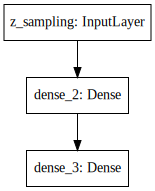

In [22]:
vae.compile(optimizer='adam', loss='binary_crossentropy')
vae.summary()
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))

### Run the AutoEncoder model

In [23]:
vae.fit(training_data, training_data, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Train on 13500 samples, validate on 1500 samples
Epoch 1/4
13500/13500 [==============================] - 125s 9ms/step - loss: 0.0104 - val_loss: 0.0029
Epoch 2/4
13500/13500 [==============================] - 114s 8ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 3/4
13500/13500 [==============================] - 114s 8ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 4/4
13500/13500 [==============================] - 116s 9ms/step - loss: 0.0028 - val_loss: 0.0028


In [24]:
training_data_encoded = encoder.predict(training_data, batch_size=batch_size)
training_data_encoded[0].shape

(15000, 2)

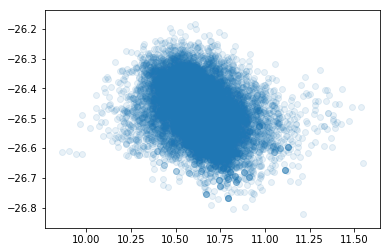

In [25]:
# Visualize latent space
plt.scatter(training_data_encoded[0][:, 0], training_data_encoded[0][:, 1], alpha=0.1)